In [17]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from IPython.display import HTML, display
from tensorflow.keras import regularizers
import os
! pip install tabulate
import tabulate
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [4]:
def scale(x, switch):
    
    if switch:
        return x - np.max(x)
    else: 
        return (x - np.mean(x)) / np.std(x)

In [5]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

### 1. Generate Data

In [9]:
def generate_data(switch):
    
    os.chdir("/home/pk2573/Capstone_Data/Re15sh20_DNScoarse8")
    u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"], switch))
    v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"], switch))
    w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"], switch))
    tau_12 = preprocess(scale(loadmat('tau12_xyz_T1.mat')["tau12"], switch))
    tau_13 = preprocess(scale(loadmat('tau13_xyz_T1.mat')["tau13"], switch))
    tau_23 = preprocess(scale(loadmat('tau23_xyz_T1.mat')["tau23"], switch))
    
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
    
    sample = []
    size = 3
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []
    for i in range(size, x.shape[0] - size):
        for j in range(size, x.shape[1] - size):
            for k in range(size, x.shape[2] - size):
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_12.append(tau_12[i - size][j - size][k - size])
                y_tau_13.append(tau_13[i - size][j - size][k - size])
                y_tau_23.append(tau_23[i - size][j - size][k - size])
                
    x = np.stack(sample, axis = 0)
    y_tau_12 = np.array(y_tau_12)
    y_tau_13 = np.array(y_tau_13)
    y_tau_23 = np.array(y_tau_23)
    
    del u
    del v
    del w
    del tau_12
    del tau_13
    del tau_23
    del sample
    gc.collect()
    
    return x, [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]

### 2. Build Model 

In [7]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
        
        return history, model

### 3. Run Model

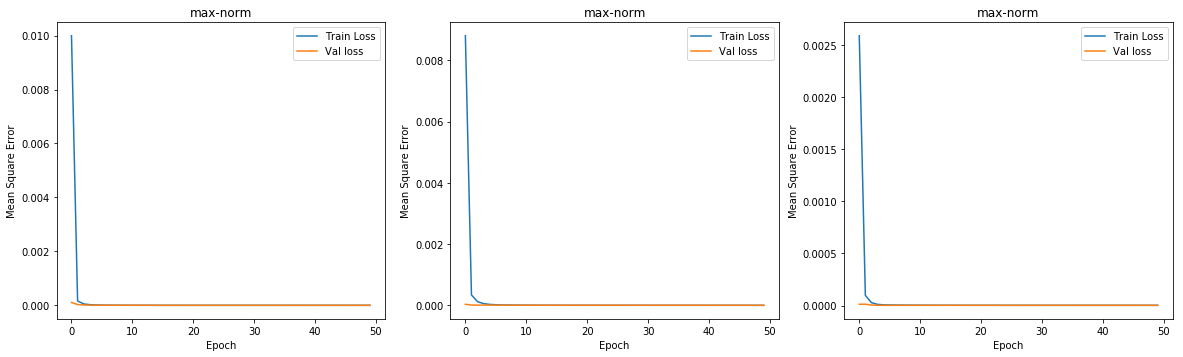

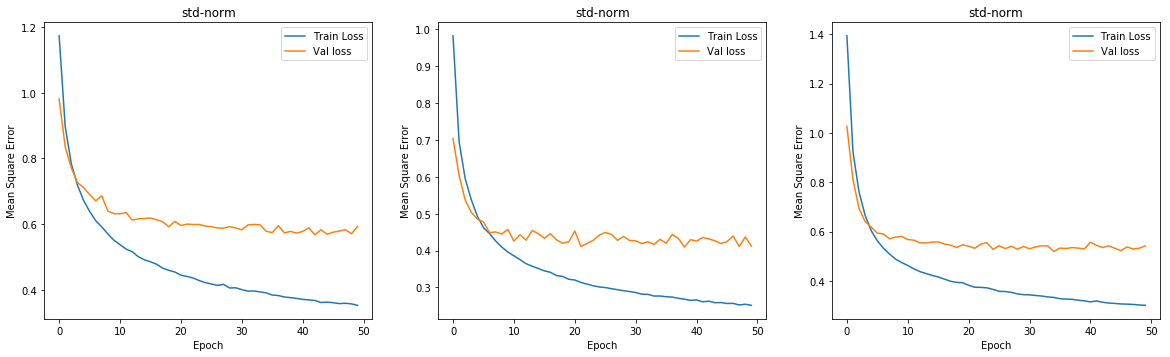

Normalization Technique,Tau_12,Tau_13,Tau_23
max-norm,0.0022,0.2661,-0.0112
std-norm,0.8453,0.8913,0.8665


In [18]:
out = [["Normalization Technique", "Tau_12", "Tau_13", "Tau_23"]]
switches = [(True, "max-norm"), (False, "std-norm")]
i = 1
for (switch, norm) in switches:
    x, taus = generate_data(switch)

    activation = tf.nn.relu
    initializer = None
    regularizer = None
    epochs = 50
    batch_size = 5000
    input_shape = (x.shape[1], x.shape[2], x.shape[3], x.shape[4])
    val_split = 0.2

    fig = plt.figure(figsize = (20, 12))
    correlation = []
    for (y, name) in taus:
        mask =  np.random.rand(x.shape[0]) < 0.80
        x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]
        y_train, y_test = y[mask], y[~mask]

        model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)
        history, model = model.run_model()

        del x_train
        del y_train
        gc.collect()

        fig.add_subplot(2, len(taus), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.title(norm)
        plt.legend()

        y_pred = model.predict(x_test).flatten()
        y_true = y_test
        correlation.append(np.corrcoef(y_pred, y_true)[0, 1])

        del x_test
        del y_true
        del y_pred
        del y_test
        del model
        del y
        gc.collect()
        i += 1
    
    out.append([norm, str(np.round(correlation[0], 4)), str(np.round(correlation[1], 4)), str(np.round(correlation[2], 4))])

plt.show()
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))